In [1]:
# Correlacionar umidade com a contagem de sementes
# Verificar Origem do df com a Camara de destino

## Importação e carregamento dos dados

In [2]:
import glob
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

import ipywidgets as widgets
from IPython.display import display

In [3]:
DADOS_DP = pd.read_parquet("dados_\Dados Brutos\PTU_DP2_SAFRA_INV25.parquet", engine="fastparquet")
DADOS_BAYER_QUA = pd.read_excel("dados_\Dados Brutos\QUA007_2025-7-30.xls")
DADOS_BAYER_VW = pd.read_excel("dados_\Dados Brutos\VW_SEC002_2025-7-30.xls")
DADOS_DB = pd.read_parquet("dados_\Dados Brutos\PTU_DBs_SAFRA_INV25.parquet", engine="fastparquet")

FileNotFoundError: [Errno 2] No such file or directory: 'dados_\\Dados Brutos\\PTU_DP2_SAFRA_INV25.parquet'

## Consolidação Dados Bayer

In [ ]:
df_bayer_qua = DADOS_BAYER_QUA.copy()
df_bayer_VW = DADOS_BAYER_VW.copy()

# Identificar as colunas que podem conter o delimitador ';'.
cols_to_split = ["Controle Secagem", "Secador.Câmara"]

# Para cada coluna a ser dividida, primeiro converta-a para o tipo string.
# Isso garante que valores nulos ou numéricos não causem erro.
# Em seguida, divida os valores pelo delimitador ';', criando listas nas células.
for col in cols_to_split:
    df_bayer_qua[col] = df_bayer_qua[col].astype(str).str.split(";")

# Utilizar a função 'explode' para expandir as listas em novas linhas.
# Esta função é a chave da solução. Ela cria uma nova linha para cada
# item em uma lista, replicando todos os outros valores da linha original.
df_qua_expanded = df_bayer_qua.explode(cols_to_split)

# Resetar o índice do DataFrame para que seja uma sequência limpa e contínua.
df_qua_expanded = df_qua_expanded.reset_index(drop=True)

# Salvar o resultado em um novo arquivo CSV para fácil visualização.
# Usar ';' como separador e ',' como decimal para compatibilidade com Excel em português.
# output_filename = 'QUA_dados_expandidos.csv'
# df_expanded.to_csv(output_filename, index=False, sep=';', decimal=',')

In [ ]:
# Garantir que a coluna-chave 'Controle Secagem' tenha o mesmo tipo de dado em ambos os DataFrames.
df_qua_expanded["Controle Secagem"] = df_qua_expanded["Controle Secagem"].astype(str)
df_bayer_VW["Controle Secagem"] = df_bayer_VW["Controle Secagem"].astype(str)

# (Opcional, mas recomendado) Remover colunas duplicadas do arquivo VW antes do merge.
# Isso evita colunas como 'Safra_x' e 'Safra_y' no resultado final.
# Identificamos as colunas que existem em ambos, exceto a chave de merge.
# cols_in_both = df_qua_expanded.columns.intersection(df_bayer_VW.columns).tolist()
# cols_to_drop = [col for col in cols_in_both if col != 'Controle Secagem']
# df_vw_cleaned = df_bayer_VW.drop(columns=cols_to_drop)

# Executar o merge
df_merged = pd.merge(df_qua_expanded, df_bayer_VW, on="Controle Secagem", how="left", suffixes=("_QUA", "_VW"))
df_merged.dropna(subset=["Controle Secagem", "Linha Descarga", "Início Debulha"], inplace=True)

# Salvar o resultado completo em um novo arquivo CSV
# output_filename = 'QUA_VW_MERGE_COMPLETO.csv'
# df_merged.to_csv(output_filename, index=False, sep=';', decimal=',')

# df_merged.columns.to_list()

In [ ]:
cols_to_keep = [
    "Híbrido RNC/Linhagem_QUA",
    "Umidade (%)",
    "Início Descarga",
    "Término Descarga",
    "Linha Descarga",
    "Controle Secagem",
    "Secador.Câmara",
    "Peso Total RW  (kg)",
    "Altura camada (m)",
    "Início Secagem",
    "Inversão Câmara",
    "Término Secagem",
    "Ressecagem",
    "Secagem (horas) Atividade 2010",
    "Início Debulha",
    "Término Debulha",
    "Umidade mínima (%)",
    "Umidade máxima (%)",
    "Umidade debulha média (%)",
    "Desvio Padrão (%)",
    "Umidade Média de Fechamento AvM%",
]
df_merged = df_merged[cols_to_keep]

# Converter em timestamp
for col in ["Início Descarga", "Término Descarga", "Início Secagem", "Inversão Câmara", "Término Secagem", "Início Debulha", "Término Debulha"]:
    df_merged[col] = pd.to_datetime(df_merged[col], dayfirst=True)

DF_BAYER = df_merged.copy()
DF_BAYER[DF_BAYER["Linha Descarga"] == 2]

,Híbrido RNC/Linhagem_QUA,Umidade (%),Início Descarga,Término Descarga,Linha Descarga,Controle Secagem,Secador.Câmara,Peso Total RW (kg),Altura camada (m),Início Secagem,...,Término Secagem,Ressecagem,Secagem (horas) Atividade 2010,Início Debulha,Término Debulha,Umidade mínima (%),Umidade máxima (%),Umidade debulha média (%),Desvio Padrão (%),Umidade Média de Fechamento AvM%
91,AS1868PRO4,31.1,2025-05-25 17:14:00,2025-05-25 20:50:00,2,26,D2.04,84010.0,3.0,2025-05-25 20:00:00,...,2025-05-29 08:45:00,NÃO,84.7500,2025-05-29 14:40:00,2025-05-29 17:00:00,10.10,13.00,11.80,0.61,13.3
92,AS1868PRO4,31.1,2025-05-25 17:14:00,2025-05-25 20:50:00,2,27,D2.11,81410.0,3.0,2025-05-26 03:00:00,...,2025-05-30 06:30:00,NÃO,99.5000,2025-05-30 08:43:00,2025-05-30 10:25:00,9.79,12.49,10.93,0.62,12.3
127,DKB260PRO4,26.8,2025-05-26 22:07:00,2025-05-27 03:38:00,2,34,D2.05,85420.0,2.8,2025-05-27 08:15:00,...,2025-05-31 00:15:00,NÃO,88.0000,2025-05-31 10:43:00,2025-05-31 13:29:00,9.94,13.00,11.02,0.59,11.4
133,DKB260PRO4,28.6,2025-05-27 04:10:00,2025-05-27 09:00:00,2,34,D2.05,85420.0,2.8,2025-05-27 08:15:00,...,2025-05-31 00:15:00,NÃO,88.0000,2025-05-31 10:43:00,2025-05-31 13:29:00,9.94,13.00,11.02,0.59,11.4
134,DKB260PRO4,28.6,2025-05-27 04:10:00,2025-05-27 09:00:00,2,38,D2.02,59465.0,2.6,2025-05-27 10:45:00,...,2025-05-31 05:45:00,NÃO,91.0000,2025-05-31 13:41:00,2025-05-31 15:07:00,10.07,11.58,10.80,0.38,12.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2500,8704PRO4,28.7,2025-07-22 08:40:00,2025-07-22 10:26:00,2,607,D2.08,75690.0,2.4,2025-07-22 12:45:00,...,2025-07-24 23:45:00,NÃO,59.0000,2025-07-25 02:35:00,2025-07-25 05:30:00,10.90,13.60,12.00,0.51,12.4
2501,8704PRO4,28.7,2025-07-22 03:20:00,2025-07-22 04:40:00,2,604,D2.06,71575.0,2.8,2025-07-22 04:47:00,...,2025-07-24 09:45:00,NÃO,52.9667,2025-07-24 15:45:00,2025-07-24 17:40:00,10.30,12.90,11.60,0.48,12.0
2507,8704PRO4,26.4,2025-07-22 05:30:00,2025-07-22 12:15:00,2,606,D2.03,73510.0,2.0,2025-07-22 08:46:00,...,2025-07-24 10:15:00,NÃO,49.4833,2025-07-24 18:00:00,2025-07-24 22:00:00,9.60,13.50,11.90,0.40,12.0
2508,8704PRO4,26.4,2025-07-22 05:30:00,2025-07-22 12:15:00,2,607,D2.08,75690.0,2.4,2025-07-22 12:45:00,...,2025-07-24 23:45:00,NÃO,59.0000,2025-07-25 02:35:00,2025-07-25 05:30:00,10.90,13.60,12.00,0.51,12.4


## Consolidação Dados TAGNA

#### Dados DP2

In [ ]:
from datetime import datetime
import pytz


def convert_datetime_timezone(df):
    # Define the target Brazilian time zone
    brazil_timezone = pytz.timezone("America/Sao_Paulo")

    df = df[["_time", "_measurement", "_value"]]
    df = df.dropna()
    df["_time"] = df["_time"].apply(lambda x: datetime.fromisoformat(x.replace("Z", "+00:00")).astimezone(brazil_timezone))
    df["_time"] = df["_time"].dt.tz_localize(None)

    return df


df_dp = DADOS_DP.copy()
df_dp = convert_datetime_timezone(df_dp)
df_dp

,_time,_measurement,_value
0,2025-05-22 00:00:00,PTU_COUNT2_VC_GRAINS1/value,8.461124562819478
1,2025-05-22 00:00:01,PTU_COUNT2_VC_GRAINS1/value,8.415004419847033
2,2025-05-22 00:00:02,PTU_COUNT2_VC_GRAINS1/value,8.734002075406433
3,2025-05-22 00:00:03,PTU_COUNT2_VC_GRAINS1/value,9.093354856066721
4,2025-05-22 00:00:05,PTU_COUNT2_VC_GRAINS1/value,7.936507936507936
...,...,...,...
18539306,2025-07-27 23:59:54,PTU_DP2_VC_PERDA2/value,0
18539307,2025-07-27 23:59:55,PTU_DP2_VC_PERDA2/value,0
18539308,2025-07-27 23:59:56,PTU_DP2_VC_PERDA2/value,0
18539309,2025-07-27 23:59:57,PTU_DP2_VC_PERDA2/value,0


In [ ]:
tags_dict = {
    "PTU_COUNT2_VC_GRAINS1/value": "COUNT_GRAINS",
    "PTU_DP2_HYB_COD/value": "HYB_COD",
    "PTU_DP2_OTM_status_atual_otimizador/value": "STATUS_OTIM",
    "PTU_DP2_RECIRCULACAO/value": "RECIRC",
    "PTU_DP2_VC_FILL2/value": "FILL",
    "PTU_DP2_VC_PERDA2/value": "PERDA",
}
df_dp["_measurement"] = df_dp["_measurement"].replace(tags_dict)

df_dp

,_time,_measurement,_value
0,2025-05-22 00:00:00,COUNT_GRAINS,8.461124562819478
1,2025-05-22 00:00:01,COUNT_GRAINS,8.415004419847033
2,2025-05-22 00:00:02,COUNT_GRAINS,8.734002075406433
3,2025-05-22 00:00:03,COUNT_GRAINS,9.093354856066721
4,2025-05-22 00:00:05,COUNT_GRAINS,7.936507936507936
...,...,...,...
18539306,2025-07-27 23:59:54,PERDA,0
18539307,2025-07-27 23:59:55,PERDA,0
18539308,2025-07-27 23:59:56,PERDA,0
18539309,2025-07-27 23:59:57,PERDA,0


In [ ]:
dfs_dp = {}

# Loop para montar o dicionario com DFs únicos para cada tag
for tag in df_dp["_measurement"].unique():
    df_tag = df_dp[df_dp["_measurement"] == tag].copy()
    dfs_dp[tag] = df_tag

In [ ]:
# Reindexar com interpolação temporal para complementar valores
def reindex_interpolating(df_tag, tag):
    df = df_tag.set_index("_time")
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()

    full_date_range = pd.date_range(start="2025-05-22 00:00:00", end="2025-07-27 23:59:59", freq="s")
    df_reindexed = df.reindex(full_date_range)

    df_reindexed["_measurement"] = df_reindexed["_measurement"].fillna(tag)
    df_reindexed["_value"] = pd.to_numeric(df_reindexed["_value"], errors="coerce")
    df_reindexed["_value"] = df_reindexed["_value"].interpolate(method="time")
    df_reindexed["_value"] = df_reindexed["_value"].ffill().bfill()  # fill head/tail gaps

    # Reset index so _time becomes a column again
    df_reindexed = df_reindexed.reset_index().rename(columns={"index": "_time"})

    return df_reindexed


dfs_dp["COUNT_GRAINS"] = reindex_interpolating(dfs_dp["COUNT_GRAINS"], "COUNT_GRAINS")
dfs_dp["FILL"] = reindex_interpolating(dfs_dp["FILL"], "FILL")
dfs_dp["PERDA"] = reindex_interpolating(dfs_dp["PERDA"], "PERDA")
dfs_dp["RECIRC"] = reindex_interpolating(dfs_dp["RECIRC"], "RECIRC")

In [ ]:
dfs_dp["COUNT_GRAINS"]

,_time,_measurement,_value
0,2025-05-22 00:00:00,COUNT_GRAINS,8.461125
1,2025-05-22 00:00:01,COUNT_GRAINS,8.415004
2,2025-05-22 00:00:02,COUNT_GRAINS,8.734002
3,2025-05-22 00:00:03,COUNT_GRAINS,9.093355
4,2025-05-22 00:00:04,COUNT_GRAINS,8.514931
...,...,...,...
5788795,2025-07-27 23:59:55,COUNT_GRAINS,38.787040
5788796,2025-07-27 23:59:56,COUNT_GRAINS,46.104770
5788797,2025-07-27 23:59:57,COUNT_GRAINS,38.223990
5788798,2025-07-27 23:59:58,COUNT_GRAINS,39.501902


In [ ]:
# Valores False, XXXX_TESTE e 0.
# Reindexar os híbridos

df_com_buraco = dfs_dp["HYB_COD"].set_index("_time")
novo_indice = pd.date_range(start="2025-05-22 00:00:00", end="2025-07-27 23:59:59", freq="s")
df_reindexado = df_com_buraco.reindex(novo_indice)
df_reindexado["_measurement"] = df_reindexado["_measurement"].fillna("HYB_COD")
df_reindexado["_value"] = df_reindexado["_value"].replace(to_replace=["False", "XXXX_TESTE", "XXXXX_TESTE", "0", None], value="UNKNOWN")
dfs_dp["HYB_COD"] = df_reindexado

dfs_dp["HYB_COD"]["_value"].unique()

array(['UNKNOWN', 'AS1868PRO4', 'DKB260PRO4', 'AG9035PRO3', 'AS1820PRO4',
       'DKB255PRO4', 'AG8701PRO4', 'DK77-02TRE', 'AS1991PRO4',
       'AS1770PRO3', 'AG8690PRO3', 'AG8606PRO4', 'DKB356PRO4',
       'L7126XDDFZT1B2', '8777PRO4', 'DKB335PRO4', '8704PRO4'],
      dtype=object)

In [ ]:
# Forward fill dps Backward fill para os valores reindexados
df_com_buraco = dfs_dp["STATUS_OTIM"].set_index("_time")
novo_indice = pd.date_range(start="2025-05-22 00:00:00", end="2025-07-27 23:59:59", freq="s")
df_reindexado = df_com_buraco.reindex(novo_indice)
df_reindexado["_measurement"] = df_reindexado["_measurement"].fillna("STATUS_OTIM")
df_reindexado["_value"] = df_reindexado["_value"].ffill()
df_reindexado["_value"] = df_reindexado["_value"].bfill()

dfs_dp["STATUS_OTIM"] = df_reindexado
dfs_dp["STATUS_OTIM"]

,_measurement,_value
2025-05-22 00:00:00,STATUS_OTIM,LINHA DESABILITADA
2025-05-22 00:00:01,STATUS_OTIM,LINHA DESABILITADA
2025-05-22 00:00:02,STATUS_OTIM,LINHA DESABILITADA
2025-05-22 00:00:03,STATUS_OTIM,LINHA DESABILITADA
2025-05-22 00:00:04,STATUS_OTIM,LINHA DESABILITADA
...,...,...
2025-07-27 23:59:55,STATUS_OTIM,LINHA DESABILITADA
2025-07-27 23:59:56,STATUS_OTIM,LINHA DESABILITADA
2025-07-27 23:59:57,STATUS_OTIM,LINHA DESABILITADA
2025-07-27 23:59:58,STATUS_OTIM,LINHA DESABILITADA


In [ ]:
dfs_dp["STATUS_OTIM"]["_value"].unique()

array(['LINHA DESABILITADA', 'AGUARDANDO MATERIAL',
       'DESCARTANDO EM AUTOMÁTICO', 'APRENDENDO 0/5', 'APRENDENDO 1/5',
       'APRENDENDO 2/5', 'APRENDENDO 3/5', 'APRENDENDO 4/5',
       'INTERPOLANDO', 'AUTOMATICO', 'APRENDENDO 1/3', 'MANUAL',
       'APRENDENDO 0/3', '0', 'DESCARTANDO EM MANUAL',
       'SEM COMUNICAÇÃO COM AUTOMAÇÃO', 'APRENDENDO 2/3'], dtype=object)

#### Dados DBs

In [ ]:
df_db = DADOS_DB.copy()
df_db = convert_datetime_timezone(df_db)

In [ ]:
# Separar em conjuntos de DFs diferentes
df_db1 = df_db[df_db["_measurement"].str.contains("DB1")].copy()
df_db2 = df_db[df_db["_measurement"].str.contains("DB2")].copy()

In [ ]:
# TODO: Fazer a substituição por esses valores no dicionário
tags_dict_db = {
    "PTU_DB1_HYB_COD/value": "HYB_COD",
    "PTU_DB1_BL_WT/value": "VAZAO",
    "PTU_DB1_ORIG/value": "ORIGEM",
    "PTU_DB1_NIR_UMID/value": "UMIDADE",
    "PTU_DB1_VC_PERDA/value": "PERDA",
    "PTU_DB2_HYB_COD/value": "HYB_COD",
    "PTU_DB2_BL_WT/value": "VAZAO",
    "PTU_DB2_ORIG/value": "ORIGEM",
    "PTU_DB2_NIR_UMID/value": "UMIDADE",
    "PTU_DB2_VC_PERDA/value": "PERDA",
}

df_db1["_measurement"] = df_db1["_measurement"].replace(tags_dict_db)
df_db2["_measurement"] = df_db2["_measurement"].replace(tags_dict_db)

df_db2

,_time,_measurement,_value
2264754,2025-05-22 14:13:15,VAZAO,17.400001525878906
2264755,2025-05-22 15:51:38,VAZAO,17.400001525878906
2264756,2025-05-22 16:31:23,VAZAO,17.400001525878906
2264757,2025-05-22 17:22:52,VAZAO,17.400001525878906
2264758,2025-05-22 19:51:03,VAZAO,17.400001525878906
...,...,...,...
4166684,2025-07-27 23:59:52,PERDA,0.15527009963989258
4166685,2025-07-27 23:59:53,PERDA,0.5474686622619629
4166686,2025-07-27 23:59:54,PERDA,0.0
4166687,2025-07-27 23:59:57,PERDA,0.2492070198059082


In [ ]:
dfs_db1 = {}
dfs_db2 = {}

# Loop para montar o dicionario com DFs únicos para cada tag
for tag in df_db1["_measurement"].unique():
    df_tag = df_db1[df_db1["_measurement"] == tag].copy()
    dfs_db1[tag] = df_tag

for tag in df_db2["_measurement"].unique():
    df_tag = df_db2[df_db2["_measurement"] == tag].copy()
    dfs_db2[tag] = df_tag

# dfs_db2["UMIDADE"]

In [ ]:
for dfs_temp in [dfs_db1, dfs_db2]:
    # Fill com interpolação
    dfs_temp["VAZAO"] = reindex_interpolating(dfs_temp["VAZAO"], "VAZAO")
    dfs_temp["UMIDADE"] = reindex_interpolating(dfs_temp["UMIDADE"], "UMIDADE")
    dfs_temp["PERDA"] = reindex_interpolating(dfs_temp["PERDA"], "PERDA")

    # Fill ORIGEM com ffill e bfill
    df_com_buraco = dfs_temp["ORIGEM"].set_index("_time")
    novo_indice = pd.date_range(start="2025-05-22 00:00:00", end="2025-07-27 23:59:59", freq="s")
    df_reindexado = df_com_buraco.reindex(novo_indice)
    df_reindexado["_measurement"] = df_reindexado["_measurement"].fillna("ORIGEM")
    df_reindexado["_value"] = df_reindexado["_value"].ffill()
    df_reindexado["_value"] = df_reindexado["_value"].bfill()
    dfs_temp["ORIGEM"] = df_reindexado

In [ ]:
for dfs_temp in [dfs_db1, dfs_db2]:
    df_com_buraco = dfs_temp["HYB_COD"].set_index("_time")
    novo_indice = pd.date_range(start="2025-05-22 00:00:00", end="2025-07-27 23:59:59", freq="s")
    df_reindexado = df_com_buraco.reindex(novo_indice)
    df_reindexado["_measurement"] = df_reindexado["_measurement"].fillna("HYB_COD")
    df_reindexado["_value"] = df_reindexado["_value"].replace(to_replace=["Sabugo", "sabugo"], value="SABUGO")
    df_reindexado["_value"] = df_reindexado["_value"].replace(to_replace=["OIU", "asgfgbngc", "False", None], value="UNKNOWN")
    dfs_temp["HYB_COD"] = df_reindexado

    dfs_temp["HYB_COD"]["_value"].unique()

In [ ]:
from functools import reduce

# Merge em um único DF usando o timestamp como chave
for var_name, dfs_dict in zip(["dfs_db1", "dfs_db2", "dfs_dp"], [dfs_db1, dfs_db2, dfs_dp]):
    dfs_renamed = []

    for name, df in dfs_dict.items():
        df = df.copy()

        # Ensure _time is a column
        if df.index.name == "_time" or "_time" not in df.columns:
            df.reset_index(inplace=True, names="_time")

        # Keep only _time and _value
        df = df[["_time", "_value"]]

        # Rename _value to the measurement name
        df.rename(columns={"_value": name}, inplace=True)

        dfs_renamed.append(df)

    # Merge all dfs on _time
    df_merged = reduce(lambda left, right: pd.merge(left, right, on="_time", how="outer"), dfs_renamed)
    df_merged = df_merged.sort_values("_time").reset_index(drop=True)

    # Assign merged df back to its original variable name
    globals()[var_name] = df_merged

#### Ajustes Finais

In [ ]:
# Conversão ORIGEM para os códigos de Câmara.Secagem da BAYER
try:
    with open("camaras.json", "r", encoding="utf-8") as arquivo:
        camaras = json.load(arquivo)

except FileNotFoundError:
    print("Erro: O arquivo não foi encontrado.")
except json.JSONDecodeError:
    print("Erro: O arquivo não contém um JSON válido.")

dfs_db1["ORIGEM"] = dfs_db1["ORIGEM"].map(camaras)
dfs_db2["ORIGEM"] = dfs_db2["ORIGEM"].map(camaras)

In [ ]:
# Correção de valores anormais de COUNT_GRAINS
dfs_dp = dfs_dp.copy()

#! Com FILL = 0 e PERDA = 0, ele deve ser 0 tbm
dfs_dp.loc[(dfs_dp["FILL"] == 0) & (dfs_dp["PERDA"] == 0), "COUNT_GRAINS"] = 0

#! A release DEV 57 (origem da Encoded 2) multiplica os valores por 1000 ao invés de 100
dfs_dp["COUNT_GRAINS"] /= 10

dfs_dp["COUNT_GRAINS"]

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
          ... 
5788795    0.0
5788796    0.0
5788797    0.0
5788798    0.0
5788799    0.0
Name: COUNT_GRAINS, Length: 5788800, dtype: float64

In [ ]:
dfs_dp[(dfs_dp["FILL"] != 0) & (dfs_dp["PERDA"] != 0)]

,_time,COUNT_GRAINS,HYB_COD,STATUS_OTIM,RECIRC,FILL,PERDA
159941,2025-05-23 20:25:41,3.162833,UNKNOWN,AGUARDANDO MATERIAL,8.0,4.478672,1.400269
159942,2025-05-23 20:25:42,3.135497,UNKNOWN,AGUARDANDO MATERIAL,8.0,4.976302,2.800537
159943,2025-05-23 20:25:43,3.108161,UNKNOWN,AGUARDANDO MATERIAL,8.0,5.473932,4.200806
159944,2025-05-23 20:25:44,3.080826,UNKNOWN,AGUARDANDO MATERIAL,8.0,5.971562,5.601074
159945,2025-05-23 20:25:45,1.825589,UNKNOWN,AGUARDANDO MATERIAL,8.0,6.469192,7.001343
...,...,...,...,...,...,...,...
5315259,2025-07-22 12:27:39,3.155386,UNKNOWN,LINHA DESABILITADA,0.0,6.813080,16.846247
5315260,2025-07-22 12:27:40,2.859833,UNKNOWN,LINHA DESABILITADA,0.0,4.542053,16.846247
5315261,2025-07-22 12:27:41,2.541796,UNKNOWN,LINHA DESABILITADA,0.0,2.271027,16.846247
5325141,2025-07-22 15:12:21,4.436566,UNKNOWN,LINHA DESABILITADA,0.0,14.040116,86.513174


<Axes: xlabel='_time'>

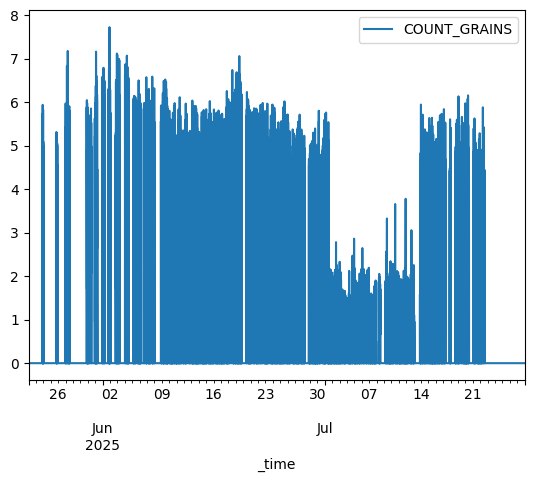

In [ ]:
# TODO: Se análise n der certo, tentar normalizar os dados (retirar média) e usar o período inteiro
dfs_dp.plot(x="_time", y="COUNT_GRAINS")

#### Dados Finais

In [ ]:
dfs_dp

,_time,COUNT_GRAINS,HYB_COD,STATUS_OTIM,RECIRC,FILL,PERDA
0,2025-05-22 00:00:00,0.0,UNKNOWN,LINHA DESABILITADA,0.0,0.0,0.0
1,2025-05-22 00:00:01,0.0,UNKNOWN,LINHA DESABILITADA,0.0,0.0,0.0
2,2025-05-22 00:00:02,0.0,UNKNOWN,LINHA DESABILITADA,0.0,0.0,0.0
3,2025-05-22 00:00:03,0.0,UNKNOWN,LINHA DESABILITADA,0.0,0.0,0.0
4,2025-05-22 00:00:04,0.0,UNKNOWN,LINHA DESABILITADA,0.0,0.0,0.0
...,...,...,...,...,...,...,...
5788795,2025-07-27 23:59:55,0.0,UNKNOWN,LINHA DESABILITADA,0.0,0.0,0.0
5788796,2025-07-27 23:59:56,0.0,UNKNOWN,LINHA DESABILITADA,0.0,0.0,0.0
5788797,2025-07-27 23:59:57,0.0,UNKNOWN,LINHA DESABILITADA,0.0,0.0,0.0
5788798,2025-07-27 23:59:58,0.0,UNKNOWN,LINHA DESABILITADA,0.0,0.0,0.0


In [ ]:
dfs_db1

,_time,VAZAO,HYB_COD,UMIDADE,ORIGEM,PERDA
0,2025-05-22 00:00:00,0.0,UNKNOWN,2.520171,D2.09,0.0
1,2025-05-22 00:00:01,0.0,UNKNOWN,2.520171,D2.09,0.0
2,2025-05-22 00:00:02,0.0,UNKNOWN,2.520171,D2.09,0.0
3,2025-05-22 00:00:03,0.0,UNKNOWN,2.520171,D2.09,0.0
4,2025-05-22 00:00:04,0.0,UNKNOWN,2.520171,D2.09,0.0
...,...,...,...,...,...,...
5788795,2025-07-27 23:59:55,12.6,UNKNOWN,10.386906,D3.34,0.0
5788796,2025-07-27 23:59:56,12.6,UNKNOWN,10.386906,D3.34,0.0
5788797,2025-07-27 23:59:57,12.6,UNKNOWN,10.386906,D3.34,0.0
5788798,2025-07-27 23:59:58,12.6,UNKNOWN,10.386906,D3.34,0.0


In [ ]:
dfs_db2

,_time,VAZAO,HYB_COD,UMIDADE,ORIGEM,PERDA
0,2025-05-22 00:00:00,17.400002,UNKNOWN,1043.342163,D1.16,0.000000
1,2025-05-22 00:00:01,17.400002,UNKNOWN,1043.342163,D1.16,0.000000
2,2025-05-22 00:00:02,17.400002,UNKNOWN,1043.342163,D1.16,0.000000
3,2025-05-22 00:00:03,17.400002,UNKNOWN,1043.342163,D1.16,0.000000
4,2025-05-22 00:00:04,17.400002,UNKNOWN,1043.342163,D1.16,0.000000
...,...,...,...,...,...,...
5788795,2025-07-27 23:59:55,18.300001,UNKNOWN,12.239599,D3.34,0.083069
5788796,2025-07-27 23:59:56,18.300001,UNKNOWN,12.230448,D3.34,0.166138
5788797,2025-07-27 23:59:57,18.300001,UNKNOWN,11.715063,D3.34,0.249207
5788798,2025-07-27 23:59:58,18.300001,UNKNOWN,11.809122,D3.34,0.343204


In [ ]:
dataframes_a_salvar = {"DF_BAYER": DF_BAYER, "DF_DP": dfs_dp, "DF_DB1": dfs_db1, "DF_DB2": dfs_db2}

output_dir = "dados_\Dados_Consolidados"
os.makedirs(output_dir, exist_ok=True)

for nome, dataframe in dataframes_a_salvar.items():
    caminho_arquivo = os.path.join(output_dir, f"{nome}.pkl")
    dataframe.to_pickle(caminho_arquivo)